In [20]:
import json
import pandas as pd
import os
from collections import defaultdict

def calculate_basic_statistics(manual_file, model_file, evaluation_file):
    
    results = {
        'manual_stats': {},
        'model_stats': {},
        'direction_analysis': {}
    }
    

    if os.path.exists(manual_file):
        with open(manual_file, 'r', encoding='utf-8') as f:
            manual_data = json.load(f)
        
        manual_triples = manual_data.get('triples', [])
        manual_action_lengths = []
        manual_directions = defaultdict(int)
        
        for triple in manual_triples:
            action = triple.get('action', '')
            manual_action_lengths.append(len(action))
            

            direction = triple.get('direction', '')
            if direction:
                manual_directions[direction] += 1
        
        results['manual_stats'] = {
            'total_triples': len(manual_triples),
            'avg_action_length': sum(manual_action_lengths) / len(manual_action_lengths) if manual_action_lengths else 0,
            'direction_counts': dict(manual_directions),
            'direction_percentages': {
                direction: count / len(manual_triples) * 100 if manual_triples else 0
                for direction, count in manual_directions.items()
            }
        }
    
    if os.path.exists(model_file):
        with open(model_file, 'r', encoding='utf-8') as f:
            model_data = json.load(f)
        
        model_triples = model_data.get('triples', [])
        model_action_lengths = []
        model_directions = defaultdict(int)
        
        for triple in model_triples:

            action = triple.get('action', '')
            model_action_lengths.append(len(action))
            
            direction = triple.get('direction', '')
            if direction:
                model_directions[direction] += 1
        
        results['model_stats'] = {
            'total_triples': len(model_triples),
            'avg_action_length': sum(model_action_lengths) / len(model_action_lengths) if model_action_lengths else 0,
            'direction_counts': dict(model_directions),
            'direction_percentages': {
                direction: count / len(model_triples) * 100 if model_triples else 0
                for direction, count in model_directions.items()
            }
        }
    
    if os.path.exists(evaluation_file):
        df = pd.read_excel(evaluation_file)
        
        direction_stats = {
            'TP': {'total': 0, 'directions': defaultdict(int)},
            'FP': {'total': 0, 'directions': defaultdict(int)},
            'FN': {'total': 0, 'directions': defaultdict(int)},
            'All': {'total': 0, 'directions': defaultdict(int)}
        }
        
        TP_categories = ['full_correct', 'potential_correct']
        FP_categories = ['potential_incorrect', 'potential_wrong_character', 'potential_redundant']
        FN_categories = ['potential_missing']
        
        for _, row in df.iterrows():
            evaluation = row.get('evaluation', '')
            match_type = row.get('match_type', '')
            
            if match_type == 'matched':
                subject = row.get('model_subject', '')
                object_ = row.get('model_object', '')
                direction = f"{subject}→{object_}" if subject and object_ and subject != '未匹配' and object_ != '未匹配' else None
                
                if direction:
                    if evaluation in TP_categories:
                        direction_stats['TP']['directions'][direction] += 1
                        direction_stats['TP']['total'] += 1
                    elif evaluation in FP_categories:
                        direction_stats['FP']['directions'][direction] += 1
                        direction_stats['FP']['total'] += 1
                    
                    direction_stats['All']['directions'][direction] += 1
                    direction_stats['All']['total'] += 1
                    
            elif match_type == 'unmatched_model':
                subject = row.get('model_subject', '')
                object_ = row.get('model_object', '')
                direction = f"{subject}→{object_}" if subject and object_ and subject != '未匹配' and object_ != '未匹配' else None
                
                if direction:
                    direction_stats['FP']['directions'][direction] += 1
                    direction_stats['FP']['total'] += 1
                    direction_stats['All']['directions'][direction] += 1
                    direction_stats['All']['total'] += 1
                    
            elif match_type == 'unmatched_manual':
                subject = row.get('manual_subject', '')
                object_ = row.get('manual_object', '')
                direction = f"{subject}→{object_}" if subject and object_ and subject != '未匹配' and object_ != '未匹配' else None
                
                if direction:
                    direction_stats['FN']['directions'][direction] += 1
                    direction_stats['FN']['total'] += 1
                    direction_stats['All']['directions'][direction] += 1
                    direction_stats['All']['total'] += 1
        
        for category in ['TP', 'FP', 'FN', 'All']:
            total = direction_stats[category]['total']
            if total > 0:
                direction_stats[category]['percentages'] = {
                    direction: count / total * 100
                    for direction, count in direction_stats[category]['directions'].items()
                }
            else:
                direction_stats[category]['percentages'] = {}
        
        results['direction_analysis'] = direction_stats
    
    return results

def create_summary_table(results):
    
    all_directions = set()
    
    if results['manual_stats'].get('direction_counts'):
        all_directions.update(results['manual_stats']['direction_counts'].keys())
    if results['model_stats'].get('direction_counts'):
        all_directions.update(results['model_stats']['direction_counts'].keys())
    if results['direction_analysis']:
        for category in ['TP', 'FP', 'FN', 'All']:
            all_directions.update(results['direction_analysis'][category]['directions'].keys())
    
    table_data = []
    for direction in sorted(all_directions):
        row = {'Direction': direction}
        
        manual_count = results['manual_stats'].get('direction_counts', {}).get(direction, 0)
        manual_percent = results['manual_stats'].get('direction_percentages', {}).get(direction, 0)
        row['Manual_Count'] = manual_count
        row['Manual_%'] = f"{manual_percent:.1f}%" if manual_percent > 0 else "0.0%"
        
        model_count = results['model_stats'].get('direction_counts', {}).get(direction, 0)
        model_percent = results['model_stats'].get('direction_percentages', {}).get(direction, 0)
        row['Model_Count'] = model_count
        row['Model_%'] = f"{model_percent:.1f}%" if model_percent > 0 else "0.0%"
        
        for category in ['TP', 'FP', 'FN']:
            if results['direction_analysis']:
                count = results['direction_analysis'][category]['directions'].get(direction, 0)
                percent = results['direction_analysis'][category]['percentages'].get(direction, 0)
                row[f'{category}_Count'] = count
                row[f'{category}_%'] = f"{percent:.1f}%" if percent > 0 else "0.0%"
        
        table_data.append(row)
    
    summary_row = {'Direction': 'TOTAL'}
    
    manual_total = results['manual_stats'].get('total_triples', 0)
    summary_row['Manual_Count'] = manual_total
    summary_row['Manual_%'] = "100.0%"
    
    model_total = results['model_stats'].get('total_triples', 0)
    summary_row['Model_Count'] = model_total
    summary_row['Model_%'] = "100.0%"
    
    if results['direction_analysis']:
        for category in ['TP', 'FP', 'FN']:
            total = results['direction_analysis'][category]['total']
            summary_row[f'{category}_Count'] = total
            summary_row[f'{category}_%'] = "100.0%"
    
    table_data.append(summary_row)
    
    df = pd.DataFrame(table_data)
    
    column_order = ['Direction', 'Manual_Count', 'Manual_%', 'Model_Count', 'Model_%']
    if results['direction_analysis']:
        column_order.extend([f'TP_Count', 'TP_%', f'FP_Count', 'FP_%', f'FN_Count', 'FN_%'])
    
    return df[column_order]

def generate_detailed_report(work_id, results, output_dir):
    
    output_file = os.path.join(output_dir, f"{work_id}_direction_analysis.xlsx")
    
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:

        basic_stats_data = []
        

        basic_stats_data.append({
            'Metric': 'Total Triples',
            'Manual': results['manual_stats'].get('total_triples', 0),
            'Model': results['model_stats'].get('total_triples', 0)
        })
        
        basic_stats_data.append({
            'Metric': 'Avg Action Length',
            'Manual': f"{results['manual_stats'].get('avg_action_length', 0):.2f}",
            'Model': f"{results['model_stats'].get('avg_action_length', 0):.2f}"
        })
        
        basic_stats_df = pd.DataFrame(basic_stats_data)
        basic_stats_df.to_excel(writer, sheet_name='Basic_Stats', index=False)
        

        direction_df = create_summary_table(results)
        direction_df.to_excel(writer, sheet_name='Direction_Distribution', index=False)
        
        if results['direction_analysis']:
            detailed_data = []
            for category in ['TP', 'FP', 'FN']:
                category_data = results['direction_analysis'][category]
                for direction, count in category_data['directions'].items():
                    percentage = category_data['percentages'].get(direction, 0)
                    detailed_data.append({
                        'Category': category,
                        'Direction': direction,
                        'Count': count,
                        'Percentage': f"{percentage:.1f}%"
                    })
            
            detailed_df = pd.DataFrame(detailed_data)
            detailed_df.to_excel(writer, sheet_name='Detailed_Analysis', index=False)
    
    return output_file

def analyze_single_work(work_id, base_dir):

    
    print(f"\n分析作品: {work_id}")
    print("-" * 40)
    

    manual_file = os.path.join(base_dir, f"{work_id}_triples.json")
    model_file = os.path.join(base_dir, "..", "triples", f"{work_id}_triples.json")
    work_dir = os.path.join(base_dir, work_id)
    evaluation_file = os.path.join(work_dir, "triples_evaluation.xlsx")
    

    results = calculate_basic_statistics(manual_file, model_file, evaluation_file)
    
    print(f"人工标注:")
    print(f"  总三元组数: {results['manual_stats']['total_triples']}")
    print(f"  Action平均长度: {results['manual_stats']['avg_action_length']:.2f} 字符")
    if results['manual_stats']['direction_counts']:
        for direction, count in results['manual_stats']['direction_counts'].items():
            percent = results['manual_stats']['direction_percentages'][direction]
            print(f"  {direction}: {count} 个 ({percent:.1f}%)")
    
    print(f"\n模型标注:")
    print(f"  总三元组数: {results['model_stats']['total_triples']}")
    print(f"  Action平均长度: {results['model_stats']['avg_action_length']:.2f} 字符")
    if results['model_stats']['direction_counts']:
        for direction, count in results['model_stats']['direction_counts'].items():
            percent = results['model_stats']['direction_percentages'][direction]
            print(f"  {direction}: {count} 个 ({percent:.1f}%)")
    
    print(f"\n评估结果方向分布:")
    if results['direction_analysis']:
        for category in ['TP', 'FP', 'FN']:
            total = results['direction_analysis'][category]['total']
            print(f"  {category}: {total} 个")
            for direction, count in results['direction_analysis'][category]['directions'].items():
                percent = results['direction_analysis'][category]['percentages'][direction]
                print(f"    {direction}: {count} 个 ({percent:.1f}%)")
    

    report_file = generate_detailed_report(work_id, results, work_dir)
    print(f"\n详细报告已生成: {report_file}")
    
    return results

def analyze_all_works(work_ids, base_dir, output_summary=True):

    
    all_results = []
    
    for work_id in work_ids:
        results = analyze_single_work(work_id, base_dir)
        if results:
            results['work_id'] = work_id
            all_results.append(results)
    

    if output_summary and all_results:
        print(f"\n{'='*60}")
        print("总体摘要")
        print(f"{'='*60}")
        
        total_manual_triples = sum(r['manual_stats']['total_triples'] for r in all_results)
        total_model_triples = sum(r['model_stats']['total_triples'] for r in all_results)
        
        avg_manual_action = sum(r['manual_stats']['avg_action_length'] for r in all_results) / len(all_results)
        avg_model_action = sum(r['model_stats']['avg_action_length'] for r in all_results) / len(all_results)
        
        print(f"人工标注总体:")
        print(f"  总三元组数: {total_manual_triples}")
        print(f"  Action平均长度: {avg_manual_action:.2f} 字符")
        
        print(f"\n模型标注总体:")
        print(f"  总三元组数: {total_model_triples}")
        print(f"  Action平均长度: {avg_model_action:.2f} 字符")
        

        overall_directions = defaultdict(lambda: {'manual': 0, 'model': 0, 'TP': 0, 'FP': 0, 'FN': 0})
        
        for result in all_results:

            for direction, count in result['manual_stats'].get('direction_counts', {}).items():
                overall_directions[direction]['manual'] += count

            for direction, count in result['model_stats'].get('direction_counts', {}).items():
                overall_directions[direction]['model'] += count

            if result['direction_analysis']:
                for category in ['TP', 'FP', 'FN']:
                    for direction, count in result['direction_analysis'][category]['directions'].items():
                        overall_directions[direction][category] += count
        
        print(f"\n总体方向分布:")
        for direction, counts in sorted(overall_directions.items()):
            manual_percent = counts['manual'] / total_manual_triples * 100 if total_manual_triples > 0 else 0
            model_percent = counts['model'] / total_model_triples * 100 if total_model_triples > 0 else 0
            
            print(f"\n{direction}:")
            print(f"  人工: {counts['manual']} 个 ({manual_percent:.1f}%)")
            print(f"  模型: {counts['model']} 个 ({model_percent:.1f}%)")
            print(f"  TP: {counts['TP']} 个")
            print(f"  FP: {counts['FP']} 个")
            print(f"  FN: {counts['FN']} 个")

def main():
    
    # 作品ID列表
    work_ids = [
        '51899716',
        '58241038', 
        '46970086',
        '61903303',
        '71788851',
        '56862190'
    ]
    

    base_dir = r"test_corpus"
    
    print("开始分析action长度和方向分布...")
    print("="*60)
    
    analyze_all_works(work_ids, base_dir)

if __name__ == "__main__":
    main()

开始分析action长度和方向分布...

分析作品: 51899716
----------------------------------------
人工标注:
  总三元组数: 82
  Action平均长度: 2.54 字符
  刘彻→卫青: 58 个 (70.7%)
  卫青→刘彻: 24 个 (29.3%)

模型标注:
  总三元组数: 51
  Action平均长度: 2.20 字符
  刘彻→卫青: 44 个 (86.3%)
  卫青→刘彻: 7 个 (13.7%)

评估结果方向分布:
  TP: 27 个
    刘彻→卫青: 24 个 (88.9%)
    卫青→刘彻: 3 个 (11.1%)
  FP: 24 个
    卫青→刘彻: 4 个 (16.7%)
    刘彻→卫青: 20 个 (83.3%)
  FN: 43 个
    卫青→刘彻: 17 个 (39.5%)
    刘彻→卫青: 26 个 (60.5%)

详细报告已生成: C:\Users\yangx\Desktop\格罗宁根岗位\2026\ChineseRPS_data\AO3_data\0119\test_corpus\51899716\51899716_direction_analysis.xlsx

分析作品: 58241038
----------------------------------------
人工标注:
  总三元组数: 21
  Action平均长度: 3.38 字符
  刘彻→卫青: 15 个 (71.4%)
  卫青→刘彻: 6 个 (28.6%)

模型标注:
  总三元组数: 18
  Action平均长度: 2.17 字符
  刘彻→卫青: 11 个 (61.1%)
  卫青→刘彻: 7 个 (38.9%)

评估结果方向分布:
  TP: 9 个
    刘彻→卫青: 6 个 (66.7%)
    卫青→刘彻: 3 个 (33.3%)
  FP: 9 个
    刘彻→卫青: 5 个 (55.6%)
    卫青→刘彻: 4 个 (44.4%)
  FN: 6 个
    刘彻→卫青: 4 个 (66.7%)
    卫青→刘彻: 2 个 (33.3%)

详细报告已生成: C:\Users\yangx\Desktop\格罗宁

Summary Statistics:
 Total Word Count  Total Triples Count  Liu Che → Wei Qing Count  Wei Qing → Liu Che Count  Liu Che → Wei Qing Percentage (%)  Wei Qing → Liu Che Percentage (%)
           501050                 3461                      2653                       808                          76.654146                          23.345854


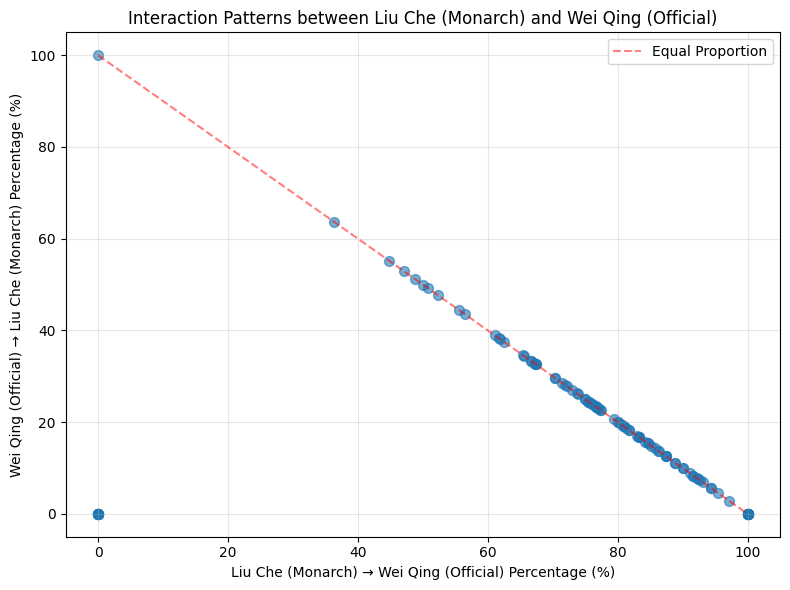

In [2]:
##
import pandas as pd
import matplotlib.pyplot as plt


csv_path = r"Liuwei_id.csv"
excel_path = r"triple_statistics.xlsx"

df_csv = pd.read_csv(csv_path)
work_ids = df_csv['work_id'].tolist()

df_excel = pd.read_excel(excel_path)
df_filtered = df_excel[df_excel['作品ID'].isin(work_ids)].copy()


total_stats = {
    'Total Word Count': df_filtered['字数统计'].sum(),
    'Total Triples Count': df_filtered['总三元组数'].sum(),
    'Liu Che → Wei Qing Count': df_filtered['刘彻→卫青数量'].sum(),
    'Wei Qing → Liu Che Count': df_filtered['卫青→刘彻数量'].sum()
}


total_interactions = total_stats['Liu Che → Wei Qing Count'] + total_stats['Wei Qing → Liu Che Count']
if total_interactions > 0:
    total_stats['Liu Che → Wei Qing Percentage (%)'] = (total_stats['Liu Che → Wei Qing Count'] / total_interactions) * 100
    total_stats['Wei Qing → Liu Che Percentage (%)'] = (total_stats['Wei Qing → Liu Che Count'] / total_interactions) * 100


summary_df = pd.DataFrame([total_stats])
print("Summary Statistics:")
print(summary_df.to_string(index=False))


plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['刘彻→卫青占比(%)'], 
            df_filtered['卫青→刘彻占比(%)'],
            alpha=0.6, s=50)

plt.xlabel('Liu Che (Monarch) → Wei Qing (Official) Percentage (%)')
plt.ylabel('Wei Qing (Official) → Liu Che (Monarch) Percentage (%)')
plt.title('Interaction Patterns between Liu Che (Monarch) and Wei Qing (Official)')
plt.grid(True, alpha=0.3)
plt.xlim(-5, 105)
plt.ylim(-5, 105)


plt.plot([0, 100], [100, 0], 'r--', alpha=0.5, label='Equal Proportion')
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import json
import os
from collections import Counter


csv_path = r"Liuwei_id.csv"
triples_folder = r"triples"


df_csv = pd.read_csv(csv_path)
work_ids = df_csv['work_id'].tolist()


wei_to_liu_counter = Counter()
liu_to_wei_counter = Counter()


for work_id in work_ids:
    json_file = f"{work_id}_triples.json"
    file_path = os.path.join(triples_folder, json_file)
    
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            for triple in data.get('triples', []):
                direction = triple.get('direction', '')
                action = triple.get('action', '').strip()
                
                if not action:
                    continue
                    
                if direction == "卫青→刘彻":
                    wei_to_liu_counter[action] += 1
                elif direction == "刘彻→卫青":
                    liu_to_wei_counter[action] += 1
                    
        except Exception as e:
            print(f"处理文件 {json_file} 时出错: {e}")


def save_action_stats(counter, filename, direction_name):
    if not counter:
        df = pd.DataFrame({'action': [], 'count': [], 'percentage': []})
    else:
        total = sum(counter.values())
        df = pd.DataFrame([
            {'action': k, 'count': v, 'percentage': round(v/total*100, 2)}
            for k, v in counter.items()
        ])
        df = df.sort_values('count', ascending=False).reset_index(drop=True)
    
    df.to_excel(filename, index=False)
    print(f"{direction_name} 统计已保存到 {filename}")
    print(f"共 {len(counter)} 种不同的action")


wei_liu_path = r"WeiLiu_statistics.xlsx"
liu_wei_path = r"LiuWei_statistics.xlsx"

save_action_stats(wei_to_liu_counter, wei_liu_path, "卫青→刘彻")
save_action_stats(liu_to_wei_counter, liu_wei_path, "刘彻→卫青")

卫青→刘彻 统计已保存到 C:\Users\yangx\Desktop\格罗宁根岗位\2026\ChineseRPS_data\AO3_data\0115\WeiLiu_statistics.xlsx
共 414 种不同的action
刘彻→卫青 统计已保存到 C:\Users\yangx\Desktop\格罗宁根岗位\2026\ChineseRPS_data\AO3_data\0115\LiuWei_statistics.xlsx
共 885 种不同的action


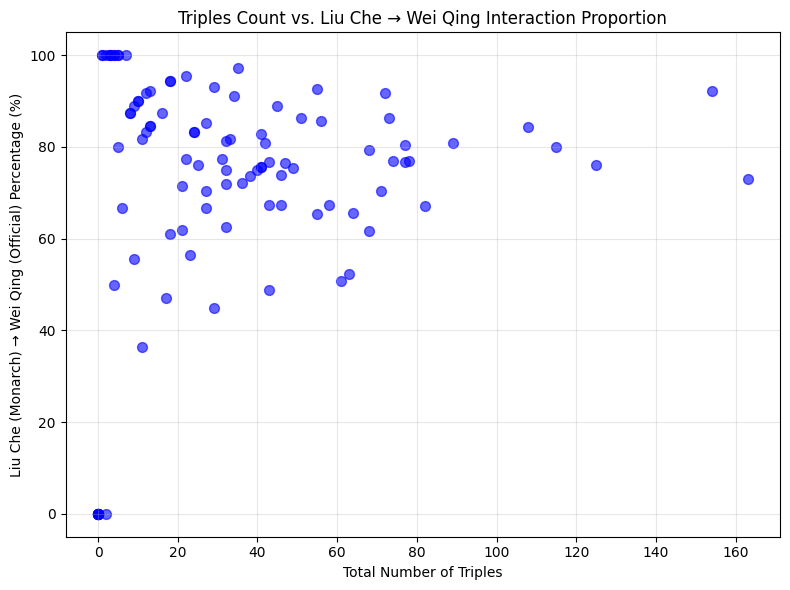

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


csv_path = r"Liuwei_id.csv"
excel_path = r"triple_statistics.xlsx"

df_csv = pd.read_csv(csv_path)
work_ids = df_csv['work_id'].tolist()

df_excel = pd.read_excel(excel_path)
df_filtered = df_excel[df_excel['作品ID'].isin(work_ids)].copy()


plt.figure(figsize=(8, 6))


plt.scatter(df_filtered['总三元组数'], 
            df_filtered['刘彻→卫青占比(%)'],
            alpha=0.6, s=50, c='blue')

plt.xlabel('Total Number of Triples')
plt.ylabel('Liu Che (Monarch) → Wei Qing (Official) Percentage (%)')
plt.title('Triples Count vs. Liu Che → Wei Qing Interaction Proportion')
plt.grid(True, alpha=0.3)


plt.ylim(-5, 105)

plt.tight_layout()
plt.show()

In [7]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ------ --------------------------------- 1.6/9.6 MB 8.4 MB/s eta 0:00:01
   ------------- -------------------------- 3.1/9.6 MB 7.7 MB/s eta 0:00:01
   ------------------- -------------------- 4.7/9.6 MB 7.9 MB/s eta 0:00:01
   --------------------------- ------------ 6.6/9.6 MB 7.7 MB/s eta 0:00:01
   -------------------------------- ------- 7.9/9.6 MB 7.6 MB/s eta 0:00:01
   ---------------------------------------  9.4/9.6 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 7.4 MB/s eta 0:00:00


图表已保存到: C:\Users\yangx\Desktop\格罗宁根岗位\2026\ChineseRPS_data\AO3_data\0115\symmetrical_action_comparison.png


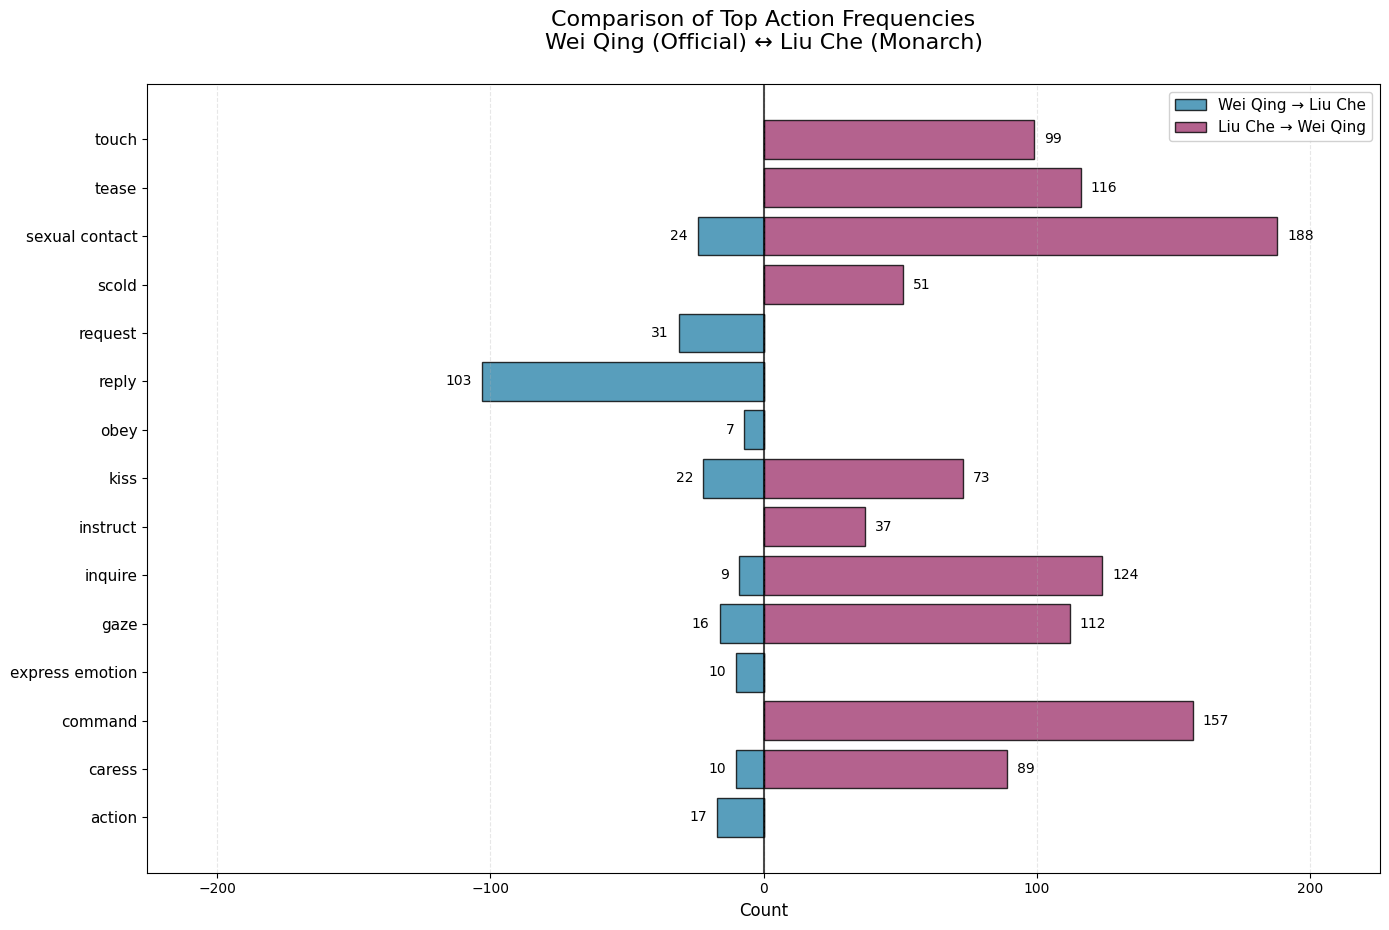

动作频率对比统计:
对比的动作数量: 15
Wei→Liu 总次数: 249
Liu→Wei 总次数: 1046
Liu→Wei / Wei→Liu 比例: 4.20倍

每个动作的详细对比:
------------------------------------------------------------
action               | Wei→Liu:   17 | Liu→Wei:    0 | 比例:   0.00
caress               | Wei→Liu:   10 | Liu→Wei:   89 | 比例:   8.90
command              | Wei→Liu:    0 | Liu→Wei:  157 | 比例:    inf
express emotion      | Wei→Liu:   10 | Liu→Wei:    0 | 比例:   0.00
gaze                 | Wei→Liu:   16 | Liu→Wei:  112 | 比例:   7.00
inquire              | Wei→Liu:    9 | Liu→Wei:  124 | 比例:  13.78
instruct             | Wei→Liu:    0 | Liu→Wei:   37 | 比例:    inf
kiss                 | Wei→Liu:   22 | Liu→Wei:   73 | 比例:   3.32
obey                 | Wei→Liu:    7 | Liu→Wei:    0 | 比例:   0.00
reply                | Wei→Liu:  103 | Liu→Wei:    0 | 比例:   0.00
request              | Wei→Liu:   31 | Liu→Wei:    0 | 比例:   0.00
scold                | Wei→Liu:    0 | Liu→Wei:   51 | 比例:    inf
sexual contact       | Wei→Liu:   24 | Liu→Wei:  1

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


file_path = r"Action_count_full.xlsx"
df = pd.read_excel(file_path)


wei_liu = df[df['Direction'] == 'Wei-Liu'].head(10)
liu_wei = df[df['Direction'] == 'Liu-Wei'].head(10)

actions_combined = list(set(wei_liu['English_action'].tolist() + liu_wei['English_action'].tolist()))
actions_combined.sort()  


fig, ax = plt.subplots(figsize=(14, 10))


wei_color = '#2E86AB'  
liu_color = '#A23B72'  


y_pos = np.arange(len(actions_combined))


wei_counts = np.zeros(len(actions_combined))
liu_counts = np.zeros(len(actions_combined))


for i, action in enumerate(actions_combined):
    # Wei→Liu方向
    wei_row = wei_liu[wei_liu['English_action'] == action]
    if not wei_row.empty:
        wei_counts[i] = wei_row['count'].values[0]
    
    # Liu→Wei方向
    liu_row = liu_wei[liu_wei['English_action'] == action]
    if not liu_row.empty:
        liu_counts[i] = liu_row['count'].values[0]


ax.barh(y_pos, -wei_counts, color=wei_color, alpha=0.8, edgecolor='black', 
        label='Wei Qing → Liu Che')


ax.barh(y_pos, liu_counts, color=liu_color, alpha=0.8, edgecolor='black', 
        label='Liu Che → Wei Qing')


ax.set_yticks(y_pos)
ax.set_yticklabels(actions_combined, fontsize=11)


ax.set_xlabel('Count', fontsize=12)


ax.axvline(x=0, color='black', linewidth=1.5, alpha=0.7)


for i, (wei_count, liu_count) in enumerate(zip(wei_counts, liu_counts)):
    if wei_count > 0:
        ax.text(-wei_count - max(liu_counts.max(), wei_counts.max())*0.02, 
                i, f'{int(wei_count)}', 
                ha='right', va='center', fontsize=10)
    if liu_count > 0:
        ax.text(liu_count + max(liu_counts.max(), wei_counts.max())*0.02, 
                i, f'{int(liu_count)}', 
                ha='left', va='center', fontsize=10)


plt.title('Comparison of Top Action Frequencies\nWei Qing (Official) ↔ Liu Che (Monarch)', 
          fontsize=16, pad=25)


ax.legend(loc='upper right', fontsize=11, framealpha=0.9)


max_count = max(liu_counts.max(), wei_counts.max())
ax.set_xlim(-max_count * 1.2, max_count * 1.2)


ax.grid(axis='x', alpha=0.3, linestyle='--')



plt.tight_layout(rect=[0, 0.03, 1, 0.97])  


output_path = r"symmetrical_action_comparison.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"图表已保存到: {output_path}")

plt.show()


print("="*60)
print("动作频率对比统计:")
print("="*60)
print(f"对比的动作数量: {len(actions_combined)}")
print(f"Wei→Liu 总次数: {wei_counts.sum():.0f}")
print(f"Liu→Wei 总次数: {liu_counts.sum():.0f}")
print(f"Liu→Wei / Wei→Liu 比例: {liu_counts.sum()/wei_counts.sum():.2f}倍")


print("\n每个动作的详细对比:")
print("-"*60)
for i, action in enumerate(actions_combined):
    if wei_counts[i] > 0 or liu_counts[i] > 0:
        ratio = liu_counts[i]/wei_counts[i] if wei_counts[i] > 0 else float('inf')
        print(f"{action:20s} | Wei→Liu: {wei_counts[i]:4.0f} | Liu→Wei: {liu_counts[i]:4.0f} | 比例: {ratio:6.2f}")

LOESS拟合统计信息:
数据点数: 102
Bootstrap次数: 100
LOESS平滑参数 (frac): 0.3
拟合点数量: 102
平均置信区间带宽: 30.93%
在 x ≈ 3.0 处跨越50%阈值
整体趋势斜率: 0.501790
趋势: 随三元组增加而上升

图表已保存到: C:\Users\yangx\Desktop\格罗宁根岗位\2026\ChineseRPS_data\AO3_data\0115\loess_with_ci.png


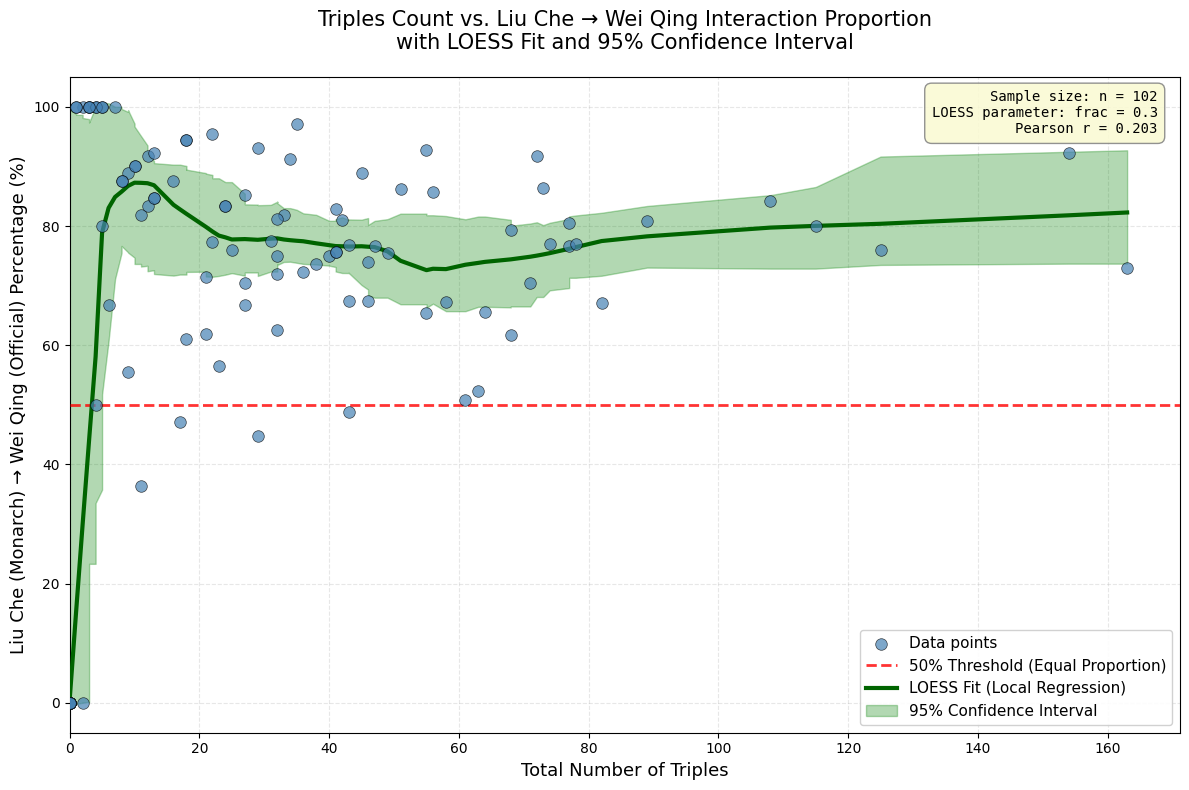


数据分布统计:
总作品数: 102
有效数据点数: 102
刘彻→卫青占比平均值: 71.28%
刘彻→卫青占比中位数: 77.15%
总三元组数平均值: 33.93
总三元组数中位数: 27.00
相关性 (Pearson): 0.2032


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats


csv_path = r"Liuwei_id.csv"
excel_path = r"triple_statistics.xlsx"

df_csv = pd.read_csv(csv_path)
work_ids = df_csv['work_id'].tolist()

df_excel = pd.read_excel(excel_path)
df_filtered = df_excel[df_excel['作品ID'].isin(work_ids)].copy()


plt.figure(figsize=(12, 8))


x_data = df_filtered['总三元组数']
y_data = df_filtered['刘彻→卫青占比(%)']


scatter = plt.scatter(x_data, y_data, alpha=0.7, s=70, c='steelblue', 
                      edgecolors='black', linewidth=0.5, zorder=5, label='Data points')


plt.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.8, 
            label='50% Threshold (Equal Proportion)', zorder=3)


if len(x_data) > 2:

    valid_mask = (~np.isnan(x_data)) & (~np.isnan(y_data))
    x_valid = x_data[valid_mask].values
    y_valid = y_data[valid_mask].values
    
    if len(x_valid) > 10: 

        n_bootstrap = 100  
        frac = 0.3  
        bootstrap_fits = []
        

        np.random.seed(42)  
        n_samples = len(x_valid)
        
        for _ in range(n_bootstrap):

            indices = np.random.choice(n_samples, n_samples, replace=True)
            x_boot = x_valid[indices]
            y_boot = y_valid[indices]
            

            try:
                loess_boot = lowess(y_boot, x_boot, frac=frac, it=3, return_sorted=True)
                bootstrap_fits.append(loess_boot[:, 1])
            except:
                continue
        
        if bootstrap_fits:

            loess_fit = lowess(y_valid, x_valid, frac=frac, it=3)
            x_sorted = loess_fit[:, 0]
            y_smooth = loess_fit[:, 1]
            

            bootstrap_matrix = np.array(bootstrap_fits)

            ci_lower = np.percentile(bootstrap_matrix, 2.5, axis=0)
            ci_upper = np.percentile(bootstrap_matrix, 97.5, axis=0)
            

            plt.plot(x_sorted, y_smooth, color='darkgreen', linewidth=3, 
                     label='LOESS Fit (Local Regression)', zorder=4)
            

            plt.fill_between(x_sorted, ci_lower, ci_upper, color='green', 
                            alpha=0.3, label='95% Confidence Interval', zorder=2)
            

            print("=" * 60)
            print("LOESS拟合统计信息:")
            print("=" * 60)
            print(f"数据点数: {len(x_valid)}")
            print(f"Bootstrap次数: {n_bootstrap}")
            print(f"LOESS平滑参数 (frac): {frac}")
            print(f"拟合点数量: {len(x_sorted)}")
            

            avg_bandwidth = np.mean(ci_upper - ci_lower)
            print(f"平均置信区间带宽: {avg_bandwidth:.2f}%")
            

            below_50 = y_smooth < 50
            above_50 = y_smooth > 50
            
            if np.any(below_50) and np.any(above_50):

                cross_idx = np.where(np.diff(below_50.astype(int)) != 0)[0]
                if len(cross_idx) > 0:
                    for idx in cross_idx:
                        cross_x = x_sorted[idx]
                        print(f"在 x ≈ {cross_x:.1f} 处跨越50%阈值")
            

            slope_trend = (y_smooth[-1] - y_smooth[0]) / (x_sorted[-1] - x_sorted[0])
            print(f"整体趋势斜率: {slope_trend:.6f}")
            if abs(slope_trend) < 0.0001:
                print("趋势: 基本平稳")
            elif slope_trend > 0:
                print("趋势: 随三元组增加而上升")
            else:
                print("趋势: 随三元组增加而下降")


elif len(x_valid) > 1:

    slope, intercept, r_value, p_value, std_err = stats.linregress(x_valid, y_valid)
    

    x_fit = np.linspace(x_valid.min(), x_valid.max(), 100)
    y_fit = intercept + slope * x_fit
    

    n = len(x_valid)
    x_mean = np.mean(x_valid)
    Sxx = np.sum((x_valid - x_mean) ** 2)
    se_y = std_err * np.sqrt(1/n + (x_fit - x_mean)**2 / Sxx)
    t_critical = stats.t.ppf(0.975, n-2)
    ci_upper = y_fit + t_critical * se_y
    ci_lower = y_fit - t_critical * se_y
    

    plt.plot(x_fit, y_fit, color='darkgreen', linewidth=3, 
             label=f'Linear Fit (R² = {r_value**2:.3f})', zorder=4)
    plt.fill_between(x_fit, ci_lower, ci_upper, color='green', 
                     alpha=0.3, label='95% Confidence Interval', zorder=2)
    
    print("=" * 60)
    print("线性回归统计信息 (LOESS不可用):")
    print("=" * 60)
    print(f"数据点数: {n}")
    print(f"斜率: {slope:.6f}")
    print(f"截距: {intercept:.4f}")
    print(f"R²: {r_value**2:.4f}")
    print(f"P值: {p_value:.6f}")


plt.xlabel('Total Number of Triples', fontsize=13)
plt.ylabel('Liu Che (Monarch) → Wei Qing (Official) Percentage (%)', 
           fontsize=13)
plt.title('Triples Count vs. Liu Che → Wei Qing Interaction Proportion\nwith LOESS Fit and 95% Confidence Interval', 
          fontsize=15, pad=20)

plt.ylim(-5, 105)
plt.xlim(0, x_data.max() * 1.05)


plt.grid(True, alpha=0.3, linestyle='--', zorder=1)


plt.legend(loc='best', fontsize=11, framealpha=0.9)


if len(x_valid) > 10:

    stats_lines = []
    stats_lines.append(f"Sample size: n = {len(x_valid)}")
    stats_lines.append(f"LOESS parameter: frac = {frac}")
    
    if 'r_value' in locals():
        stats_lines.append(f"Linear R² = {r_value**2:.3f}")
    

    if len(x_valid) > 2:
        pearson_corr, pearson_p = stats.pearsonr(x_valid, y_valid)
        stats_lines.append(f"Pearson r = {pearson_corr:.3f}")
    
    stats_text = "\n".join(stats_lines)
    

    plt.text(0.98, 0.98, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', 
                      facecolor='lightgoldenrodyellow', 
                      edgecolor='gray', 
                      alpha=0.85,
                      linewidth=1),
             fontsize=10, 
             fontfamily='monospace', 
             zorder=6)

plt.tight_layout()


output_path = r"loess_with_ci.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\n图表已保存到: {output_path}")

plt.show()


print("\n" + "=" * 60)
print("数据分布统计:")
print("=" * 60)
print(f"总作品数: {len(df_filtered)}")
print(f"有效数据点数: {len(x_valid) if 'x_valid' in locals() else 0}")
print(f"刘彻→卫青占比平均值: {y_data.mean():.2f}%")
print(f"刘彻→卫青占比中位数: {y_data.median():.2f}%")
print(f"总三元组数平均值: {x_data.mean():.2f}")
print(f"总三元组数中位数: {x_data.median():.2f}")
print(f"相关性 (Pearson): {stats.pearsonr(x_valid, y_valid)[0]:.4f}" if len(x_valid) > 1 else "相关性: 数据不足")